# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

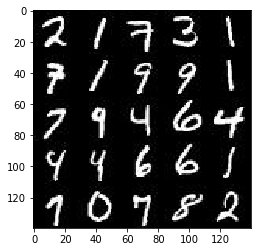

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

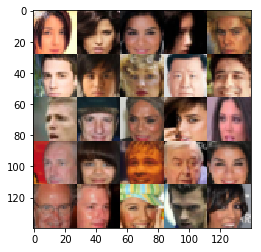

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1


/home/gilgamesh/anaconda2/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [91]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32,shape=(None,image_width,image_height,image_channels))
    z = tf.placeholder(tf.float32,shape=(None,z_dim))
    lr = tf.placeholder(tf.float32,shape=None)

    return real_input_images, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/gilgamesh/anaconda2/envs/env/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/gilgamesh/anaconda2/envs/env/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/gilgamesh/anaconda2/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/gilgamesh/anaconda2/envs/env/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/gilgamesh/anaconda2/envs/env/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "/hom

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [92]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        alpha = 0.01
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        #print(x1.get_shape())
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        #print(x2.get_shape())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [93]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=not is_train):
        alpha = 0.01
        x1 = tf.layers.dense(z,7*7*128)
        #reshaping to 4d tensor
        x1 = tf.reshape(x1,(-1,7,7,128))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #print(x1.get_shape())
        #? x 7 x 7 x 128
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2.get_shape())
        #? x 14 x 14 x 256
        
        logits = tf.layers.conv2d_transpose(x2,out_channel_dim,5,strides=2,padding='same')
        #print(logits.get_shape())
        
        out = tf.tanh(logits)
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [94]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    gen_model = generator(input_z,out_channel_dim)
    dis_model_real,dis_logits_real = discriminator(input_real)
    dis_model_fake,dis_logits_fake = discriminator(gen_model,True)
    
    dis_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_real,labels=tf.ones_like(dis_model_real)))
    dis_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake,labels=tf.zeros_like(dis_model_fake)))
    dis_loss = dis_loss_real + dis_loss_fake
        
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake,labels=tf.ones_like(dis_model_fake)))
    
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [103]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    model_vars = tf.trainable_variables()
    gen_vars = [v1 for v1 in model_vars if v1.name.startswith('generator')]
    dis_vars = [v1 for v1 in model_vars if v1.name.startswith('discriminator')]

    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [104]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [111]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    show_every = 50
    print_every = 10
    print(data_shape)
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, len(data_image_mode))
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    step = 0 
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        losses = []
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                #print(batch_images)
                step = step+1
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real:batch_images, input_z:batch_z,lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images,lr:learning_rate})

                if step % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if step % show_every == 0:
                    show_generator_output(sess,20,input_z,data_shape[3],data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch 1/2... Discriminator Loss: 0.0156... Generator Loss: 4.1807
Epoch 1/2... Discriminator Loss: 1.8455... Generator Loss: 0.2524
Epoch 1/2... Discriminator Loss: 0.0028... Generator Loss: 7.2635
Epoch 1/2... Discriminator Loss: 0.0117... Generator Loss: 5.1253
Epoch 1/2... Discriminator Loss: 0.0321... Generator Loss: 12.8132


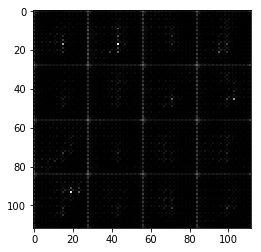

Epoch 1/2... Discriminator Loss: 0.8822... Generator Loss: 2.4834
Epoch 1/2... Discriminator Loss: 0.5048... Generator Loss: 2.2370
Epoch 1/2... Discriminator Loss: 1.1471... Generator Loss: 3.0498
Epoch 1/2... Discriminator Loss: 1.4142... Generator Loss: 0.5358
Epoch 1/2... Discriminator Loss: 1.7886... Generator Loss: 1.5378


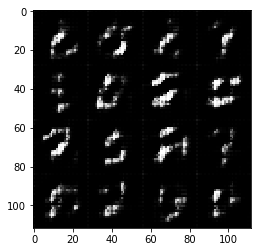

Epoch 1/2... Discriminator Loss: 0.9879... Generator Loss: 1.3008
Epoch 1/2... Discriminator Loss: 2.3046... Generator Loss: 0.1641
Epoch 1/2... Discriminator Loss: 2.0308... Generator Loss: 0.2335
Epoch 1/2... Discriminator Loss: 1.7980... Generator Loss: 0.2955
Epoch 1/2... Discriminator Loss: 1.3148... Generator Loss: 0.7179


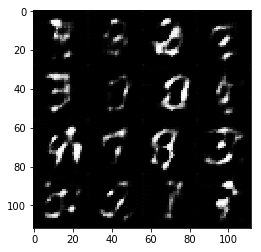

Epoch 1/2... Discriminator Loss: 1.4223... Generator Loss: 1.0563
Epoch 1/2... Discriminator Loss: 1.0617... Generator Loss: 0.8081
Epoch 1/2... Discriminator Loss: 1.3096... Generator Loss: 2.0627
Epoch 1/2... Discriminator Loss: 1.3495... Generator Loss: 0.5289
Epoch 1/2... Discriminator Loss: 0.8311... Generator Loss: 1.6251


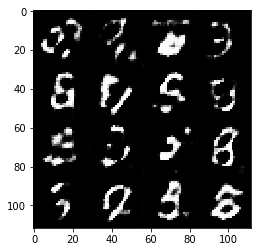

Epoch 1/2... Discriminator Loss: 1.0484... Generator Loss: 0.8710
Epoch 1/2... Discriminator Loss: 1.4609... Generator Loss: 0.3599
Epoch 1/2... Discriminator Loss: 1.0025... Generator Loss: 3.0173
Epoch 1/2... Discriminator Loss: 1.1487... Generator Loss: 0.7150
Epoch 1/2... Discriminator Loss: 1.2034... Generator Loss: 2.1290


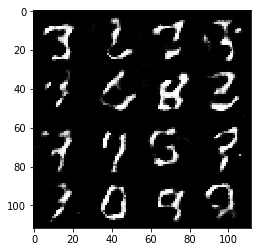

Epoch 1/2... Discriminator Loss: 1.1121... Generator Loss: 1.3572
Epoch 1/2... Discriminator Loss: 1.2639... Generator Loss: 0.6724
Epoch 1/2... Discriminator Loss: 0.8627... Generator Loss: 1.6398
Epoch 1/2... Discriminator Loss: 0.8847... Generator Loss: 1.4568
Epoch 1/2... Discriminator Loss: 1.6441... Generator Loss: 0.3205


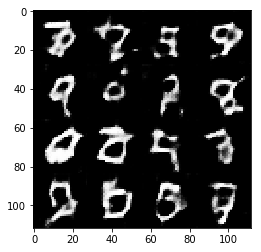

Epoch 1/2... Discriminator Loss: 1.1871... Generator Loss: 1.4321
Epoch 1/2... Discriminator Loss: 1.0729... Generator Loss: 1.6727
Epoch 1/2... Discriminator Loss: 1.2782... Generator Loss: 0.4709
Epoch 1/2... Discriminator Loss: 1.2803... Generator Loss: 1.2683
Epoch 1/2... Discriminator Loss: 1.0512... Generator Loss: 1.0954


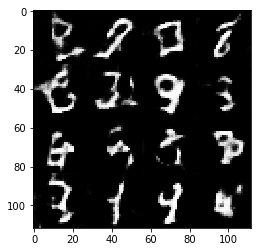

Epoch 1/2... Discriminator Loss: 1.2029... Generator Loss: 0.8820
Epoch 1/2... Discriminator Loss: 1.3669... Generator Loss: 0.4541
Epoch 1/2... Discriminator Loss: 1.6907... Generator Loss: 0.3132
Epoch 1/2... Discriminator Loss: 1.3168... Generator Loss: 0.6973
Epoch 1/2... Discriminator Loss: 1.3128... Generator Loss: 1.2078


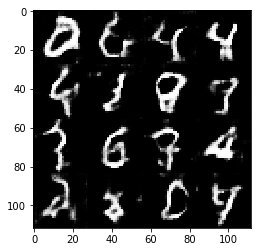

Epoch 1/2... Discriminator Loss: 1.4426... Generator Loss: 0.3886
Epoch 1/2... Discriminator Loss: 1.2336... Generator Loss: 0.5790
Epoch 1/2... Discriminator Loss: 0.8761... Generator Loss: 1.4303
Epoch 1/2... Discriminator Loss: 1.2283... Generator Loss: 0.6402
Epoch 1/2... Discriminator Loss: 1.1141... Generator Loss: 1.1370


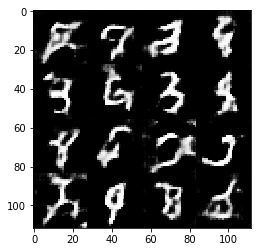

Epoch 1/2... Discriminator Loss: 1.1621... Generator Loss: 0.6927
Epoch 1/2... Discriminator Loss: 1.2157... Generator Loss: 1.0389
Epoch 1/2... Discriminator Loss: 1.2406... Generator Loss: 0.6227
Epoch 1/2... Discriminator Loss: 1.0194... Generator Loss: 1.0488
Epoch 1/2... Discriminator Loss: 1.0022... Generator Loss: 2.4141


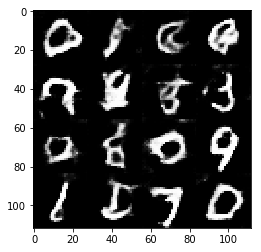

Epoch 1/2... Discriminator Loss: 1.6704... Generator Loss: 0.2685
Epoch 1/2... Discriminator Loss: 1.4027... Generator Loss: 0.4227
Epoch 1/2... Discriminator Loss: 1.2878... Generator Loss: 1.6754
Epoch 1/2... Discriminator Loss: 1.3749... Generator Loss: 0.4688
Epoch 1/2... Discriminator Loss: 1.5593... Generator Loss: 0.3200


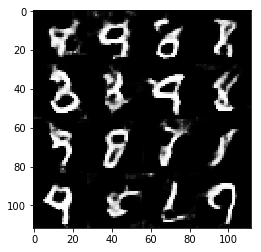

Epoch 1/2... Discriminator Loss: 1.2356... Generator Loss: 0.9754
Epoch 1/2... Discriminator Loss: 1.3023... Generator Loss: 1.9647
Epoch 1/2... Discriminator Loss: 1.8465... Generator Loss: 0.2336
Epoch 1/2... Discriminator Loss: 1.1655... Generator Loss: 0.6926
Epoch 1/2... Discriminator Loss: 1.5078... Generator Loss: 0.3203


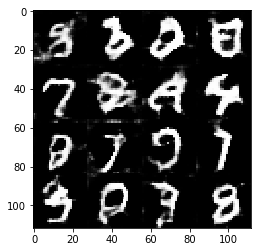

Epoch 1/2... Discriminator Loss: 1.8750... Generator Loss: 0.2319
Epoch 1/2... Discriminator Loss: 1.2271... Generator Loss: 1.2434
Epoch 1/2... Discriminator Loss: 1.1913... Generator Loss: 0.7811
Epoch 1/2... Discriminator Loss: 1.1464... Generator Loss: 0.9609
Epoch 1/2... Discriminator Loss: 1.4179... Generator Loss: 1.9605


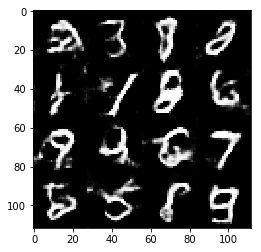

Epoch 1/2... Discriminator Loss: 1.3815... Generator Loss: 0.4079
Epoch 1/2... Discriminator Loss: 1.1544... Generator Loss: 0.7910
Epoch 1/2... Discriminator Loss: 1.2188... Generator Loss: 0.7585
Epoch 1/2... Discriminator Loss: 1.2936... Generator Loss: 0.5622
Epoch 1/2... Discriminator Loss: 1.4585... Generator Loss: 2.2110


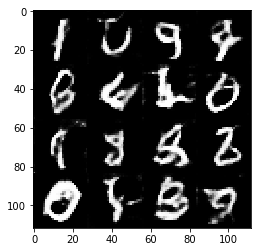

Epoch 1/2... Discriminator Loss: 1.2919... Generator Loss: 1.3933
Epoch 1/2... Discriminator Loss: 1.8322... Generator Loss: 0.2734
Epoch 1/2... Discriminator Loss: 1.6794... Generator Loss: 0.2542
Epoch 1/2... Discriminator Loss: 1.7617... Generator Loss: 0.2504
Epoch 1/2... Discriminator Loss: 1.7906... Generator Loss: 0.2336


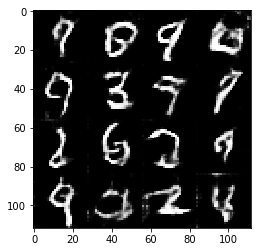

Epoch 1/2... Discriminator Loss: 1.3920... Generator Loss: 0.4488
Epoch 1/2... Discriminator Loss: 1.2191... Generator Loss: 1.0601
Epoch 1/2... Discriminator Loss: 1.3864... Generator Loss: 0.3785
Epoch 1/2... Discriminator Loss: 1.4922... Generator Loss: 0.3416
Epoch 1/2... Discriminator Loss: 1.1442... Generator Loss: 0.7458


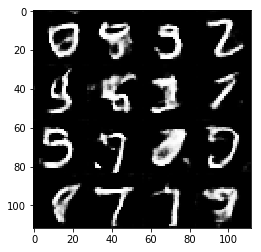

Epoch 1/2... Discriminator Loss: 1.5223... Generator Loss: 0.3409
Epoch 1/2... Discriminator Loss: 1.2485... Generator Loss: 0.5809
Epoch 1/2... Discriminator Loss: 1.0373... Generator Loss: 0.9146
Epoch 1/2... Discriminator Loss: 1.2782... Generator Loss: 0.6805
Epoch 1/2... Discriminator Loss: 0.9490... Generator Loss: 2.4687


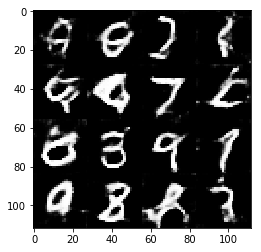

Epoch 1/2... Discriminator Loss: 1.1681... Generator Loss: 0.6852
Epoch 1/2... Discriminator Loss: 1.0191... Generator Loss: 0.8267
Epoch 1/2... Discriminator Loss: 1.0416... Generator Loss: 2.1235
Epoch 1/2... Discriminator Loss: 1.0626... Generator Loss: 0.6712
Epoch 1/2... Discriminator Loss: 1.9972... Generator Loss: 0.1815


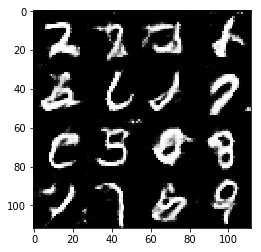

Epoch 1/2... Discriminator Loss: 1.1656... Generator Loss: 0.7811
Epoch 1/2... Discriminator Loss: 1.0508... Generator Loss: 0.9102
Epoch 1/2... Discriminator Loss: 1.8515... Generator Loss: 0.2316
Epoch 2/2... Discriminator Loss: 1.0529... Generator Loss: 1.0498
Epoch 2/2... Discriminator Loss: 1.3865... Generator Loss: 0.4261


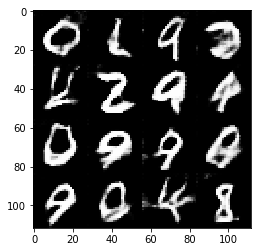

Epoch 2/2... Discriminator Loss: 1.0030... Generator Loss: 0.7524
Epoch 2/2... Discriminator Loss: 1.4072... Generator Loss: 0.3925
Epoch 2/2... Discriminator Loss: 1.1368... Generator Loss: 1.9205
Epoch 2/2... Discriminator Loss: 1.9132... Generator Loss: 0.2504
Epoch 2/2... Discriminator Loss: 1.2322... Generator Loss: 1.1629


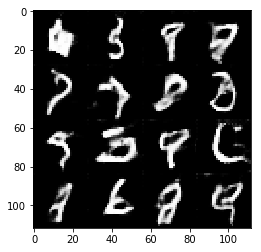

Epoch 2/2... Discriminator Loss: 1.4394... Generator Loss: 0.3696
Epoch 2/2... Discriminator Loss: 1.1305... Generator Loss: 0.6856
Epoch 2/2... Discriminator Loss: 1.0122... Generator Loss: 0.8211
Epoch 2/2... Discriminator Loss: 1.1128... Generator Loss: 0.9902
Epoch 2/2... Discriminator Loss: 1.1541... Generator Loss: 0.7160


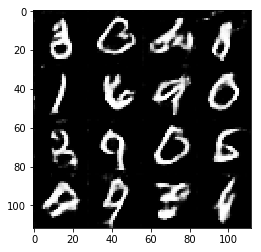

Epoch 2/2... Discriminator Loss: 1.9928... Generator Loss: 0.1818
Epoch 2/2... Discriminator Loss: 1.3216... Generator Loss: 0.5037
Epoch 2/2... Discriminator Loss: 0.9643... Generator Loss: 1.1115
Epoch 2/2... Discriminator Loss: 1.1355... Generator Loss: 0.6695
Epoch 2/2... Discriminator Loss: 0.8475... Generator Loss: 1.3694


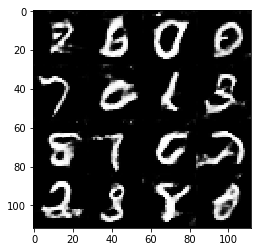

Epoch 2/2... Discriminator Loss: 1.6469... Generator Loss: 0.2833
Epoch 2/2... Discriminator Loss: 1.4897... Generator Loss: 0.3765
Epoch 2/2... Discriminator Loss: 1.0443... Generator Loss: 3.1866
Epoch 2/2... Discriminator Loss: 1.7928... Generator Loss: 0.2405
Epoch 2/2... Discriminator Loss: 1.2378... Generator Loss: 1.5410


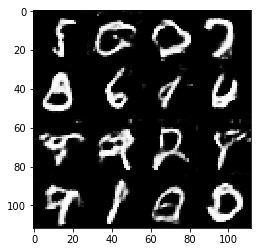

Epoch 2/2... Discriminator Loss: 1.4360... Generator Loss: 0.3805
Epoch 2/2... Discriminator Loss: 1.0403... Generator Loss: 1.2335
Epoch 2/2... Discriminator Loss: 1.7276... Generator Loss: 0.2539
Epoch 2/2... Discriminator Loss: 1.7013... Generator Loss: 0.2933
Epoch 2/2... Discriminator Loss: 2.0780... Generator Loss: 0.1976


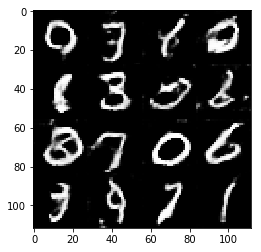

Epoch 2/2... Discriminator Loss: 1.1629... Generator Loss: 0.5443
Epoch 2/2... Discriminator Loss: 0.8210... Generator Loss: 1.7835
Epoch 2/2... Discriminator Loss: 1.1391... Generator Loss: 1.3044
Epoch 2/2... Discriminator Loss: 1.0464... Generator Loss: 0.8994
Epoch 2/2... Discriminator Loss: 1.0329... Generator Loss: 0.7930


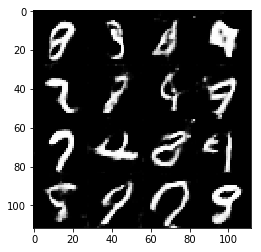

Epoch 2/2... Discriminator Loss: 1.0866... Generator Loss: 1.0745
Epoch 2/2... Discriminator Loss: 1.2404... Generator Loss: 0.8057
Epoch 2/2... Discriminator Loss: 1.0601... Generator Loss: 0.7344
Epoch 2/2... Discriminator Loss: 1.2032... Generator Loss: 0.6496
Epoch 2/2... Discriminator Loss: 1.1316... Generator Loss: 0.7690


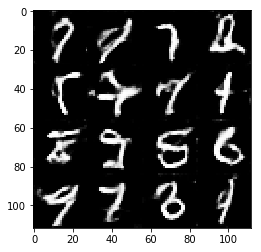

Epoch 2/2... Discriminator Loss: 1.1265... Generator Loss: 0.7261
Epoch 2/2... Discriminator Loss: 1.2122... Generator Loss: 1.4545
Epoch 2/2... Discriminator Loss: 1.1651... Generator Loss: 0.7224
Epoch 2/2... Discriminator Loss: 1.3979... Generator Loss: 1.7023
Epoch 2/2... Discriminator Loss: 1.0797... Generator Loss: 0.8336


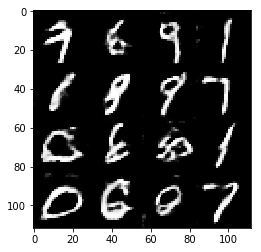

Epoch 2/2... Discriminator Loss: 1.1473... Generator Loss: 0.6964
Epoch 2/2... Discriminator Loss: 1.2337... Generator Loss: 0.7149
Epoch 2/2... Discriminator Loss: 1.1695... Generator Loss: 0.9486
Epoch 2/2... Discriminator Loss: 1.1838... Generator Loss: 1.4233
Epoch 2/2... Discriminator Loss: 0.9740... Generator Loss: 0.8069


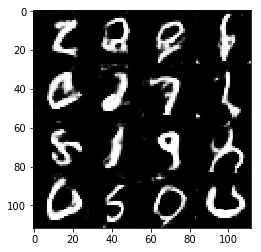

Epoch 2/2... Discriminator Loss: 1.0526... Generator Loss: 0.9535
Epoch 2/2... Discriminator Loss: 1.0032... Generator Loss: 1.3348
Epoch 2/2... Discriminator Loss: 0.8302... Generator Loss: 1.5228
Epoch 2/2... Discriminator Loss: 0.7167... Generator Loss: 2.0443
Epoch 2/2... Discriminator Loss: 1.7689... Generator Loss: 0.3067


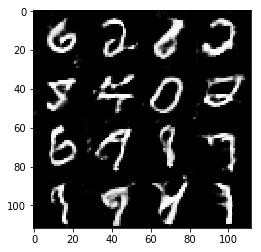

Epoch 2/2... Discriminator Loss: 1.4305... Generator Loss: 0.4758
Epoch 2/2... Discriminator Loss: 1.6600... Generator Loss: 0.3144
Epoch 2/2... Discriminator Loss: 0.8544... Generator Loss: 1.4407
Epoch 2/2... Discriminator Loss: 0.8775... Generator Loss: 2.0918
Epoch 2/2... Discriminator Loss: 1.0868... Generator Loss: 0.6860


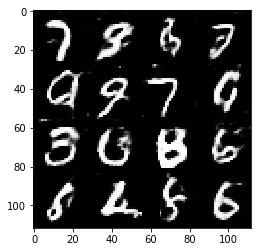

Epoch 2/2... Discriminator Loss: 1.5285... Generator Loss: 0.3607
Epoch 2/2... Discriminator Loss: 0.7349... Generator Loss: 1.5910
Epoch 2/2... Discriminator Loss: 1.0621... Generator Loss: 1.6153
Epoch 2/2... Discriminator Loss: 1.4563... Generator Loss: 0.4214
Epoch 2/2... Discriminator Loss: 1.9300... Generator Loss: 0.2008


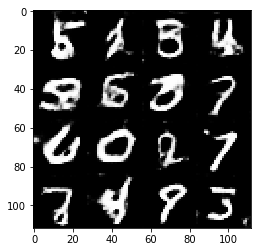

Epoch 2/2... Discriminator Loss: 1.0218... Generator Loss: 0.7296
Epoch 2/2... Discriminator Loss: 0.9768... Generator Loss: 1.5259
Epoch 2/2... Discriminator Loss: 1.0045... Generator Loss: 0.9477
Epoch 2/2... Discriminator Loss: 1.3869... Generator Loss: 2.1250
Epoch 2/2... Discriminator Loss: 1.2418... Generator Loss: 0.5296


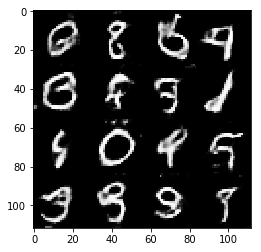

Epoch 2/2... Discriminator Loss: 0.8734... Generator Loss: 1.0741
Epoch 2/2... Discriminator Loss: 1.0945... Generator Loss: 2.6667
Epoch 2/2... Discriminator Loss: 1.1711... Generator Loss: 0.5510
Epoch 2/2... Discriminator Loss: 1.1302... Generator Loss: 1.0212
Epoch 2/2... Discriminator Loss: 1.1120... Generator Loss: 0.7232


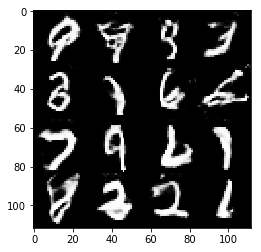

Epoch 2/2... Discriminator Loss: 0.8801... Generator Loss: 1.1811
Epoch 2/2... Discriminator Loss: 1.0201... Generator Loss: 1.5084
Epoch 2/2... Discriminator Loss: 0.9663... Generator Loss: 0.9719
Epoch 2/2... Discriminator Loss: 0.7939... Generator Loss: 1.5708
Epoch 2/2... Discriminator Loss: 0.7489... Generator Loss: 2.0971


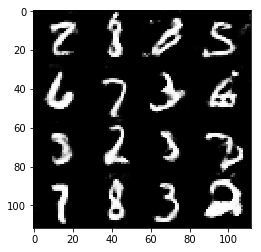

Epoch 2/2... Discriminator Loss: 2.3062... Generator Loss: 0.1411
Epoch 2/2... Discriminator Loss: 1.6904... Generator Loss: 0.2982
Epoch 2/2... Discriminator Loss: 0.9809... Generator Loss: 1.0166
Epoch 2/2... Discriminator Loss: 0.9718... Generator Loss: 0.7879
Epoch 2/2... Discriminator Loss: 1.3285... Generator Loss: 0.4345


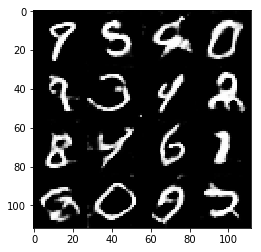

Epoch 2/2... Discriminator Loss: 1.2737... Generator Loss: 0.5297
Epoch 2/2... Discriminator Loss: 1.8951... Generator Loss: 0.2276
Epoch 2/2... Discriminator Loss: 1.0782... Generator Loss: 1.1805
Epoch 2/2... Discriminator Loss: 1.0536... Generator Loss: 0.6860
Epoch 2/2... Discriminator Loss: 1.3658... Generator Loss: 3.1020


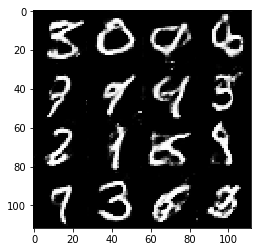

Epoch 2/2... Discriminator Loss: 1.4276... Generator Loss: 0.4479
Epoch 2/2... Discriminator Loss: 0.8874... Generator Loss: 0.8666
Epoch 2/2... Discriminator Loss: 1.3011... Generator Loss: 0.4793
Epoch 2/2... Discriminator Loss: 1.3794... Generator Loss: 0.4236
Epoch 2/2... Discriminator Loss: 1.2545... Generator Loss: 0.7176


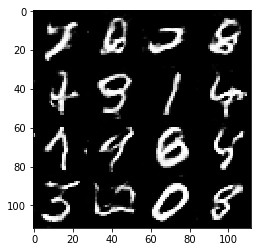

Epoch 2/2... Discriminator Loss: 1.3059... Generator Loss: 0.4606
Epoch 2/2... Discriminator Loss: 1.2301... Generator Loss: 0.6127


In [113]:
batch_size = 64
z_dim = 128
learning_rate = 0.002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.